# Predicting the presence of heart disease in a patient based on their medical and demographic information

## Introduction:
Heart disease, also known as cardiovascular disease, refers to a range of conditions that affect the heart and blood vessels. This can include coronary artery disease, heart failure, and arrhythmias. Heart disease is a global leading cause of death, with risk factors including high blood pressure, high cholesterol, smoking, and diabetes. 
The question that we plan to answer is: Can we predict the presence of heart disease in a patient based on their medical and demographic information? To answer this question, we will be using the Heart Disease dataset from the UCI Machine Learning Repository. This dataset contains information on 303 patients who underwent diagnostic testing for heart disease. The dataset includes 14 attributes, such as age, sex, cholesterol levels, and electrocardiograph readings. 


## Methods and Results:

We will be comparing the num values (Integers that state whether a patient has heart disease), to age, resting blood pressure (trestbps), cholesterol (chol), max heart rate received (thalach). These columns of data should allow us to predict whether a patient has heart disease with relative certainty. The selected columns have a wide range of values compared to the others, which have very little variation.  This should give us an accurate prediction for any patient’s data.
We will visualize the results using a scatter plot to first compare the selected variables to the num values. We can also use a scatter plot + a line plot to show the possible correlations between our selected columns and the num values.

> Add narration of code for actual analysis

In [3]:
library(tidyverse)
library(tidymodels)
library(repr)
library(rvest)
library(stringr)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Demonstrate that the dataset can be read from the web into R 

In [4]:
url <- "http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
download.file(url, destfile = "processed-cleveland.data")

### Clean and wrangle your data into a tidy format

In [5]:
heart_data <- read_csv("processed-cleveland.data",)
colnames(heart_data) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
heart_data <- heart_data |>
    mutate(num = as_factor(num))

heart_data[heart_data == "?"] <- NA

New names:
• `1.0` -> `1.0...2`
• `1.0` -> `1.0...3`
• `1.0` -> `1.0...6`
• `0.0` -> `0.0...9`
• `0.0` -> `0.0...12`
Rows: 302 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): 0.0...12, 6.0
dbl (12): 63.0, 1.0...2, 1.0...3, 145.0, 233.0, 1.0...6, 2.0, 150.0, 0.0...9...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
heart_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,NA,3.0,0


In [7]:
heart_split <- initial_split(heart_data, prop = 0.75, strata = num)  
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 

In [35]:
heart_summary <- heart_data |>
    map_df(~sum(!is.na(.)), na.rm=TRUE)
heart_summary

mean_variables <- heart_data |>
    group_by(cp) |>
    summarize(mean_age=mean(age, na.rm=TRUE),
             mean_chol=mean(chol, na.rm=TRUE),
             mean_thalach=mean(thalach, na.rm=TRUE),
             mean_oldpeak=mean(oldpeak, na.rm=TRUE))
mean_variables

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
303,303,303,303,303,303,303,303,303,303,303,299,301,303


cp,mean_age,mean_chol,mean_thalach,mean_oldpeak
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,55.86957,237.1304,155.9565,1.3913043
2,51.36000,244.7800,162.4200,0.3160000
3,53.69767,243.9651,155.4070,0.8069767
4,55.72222,250.5139,140.6806,1.3736111


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



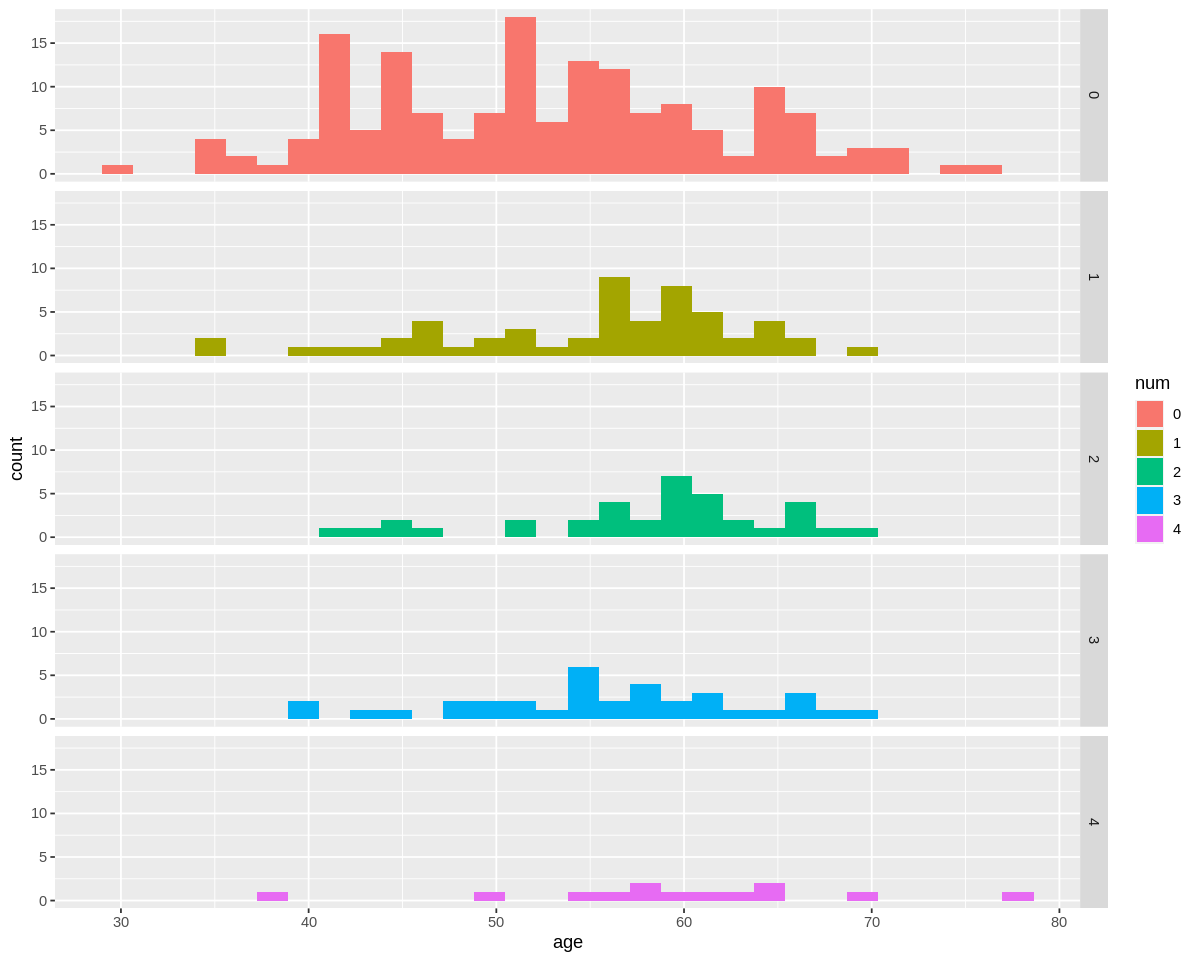

In [9]:
options(repr.plot.width = 10, repr.plot.height = 8) 

age_hist <- ggplot(heart_data, aes(x = age, fill = num)) +
    geom_histogram(position = "identity") +
    facet_grid(rows = vars(num))

age_hist

The above histogram depicts the distribution of age for each num value, depicting a clear increase in the median as the num value incrases. We can see that the median for num=0, is closer to 50, whereas the median for subsequent 

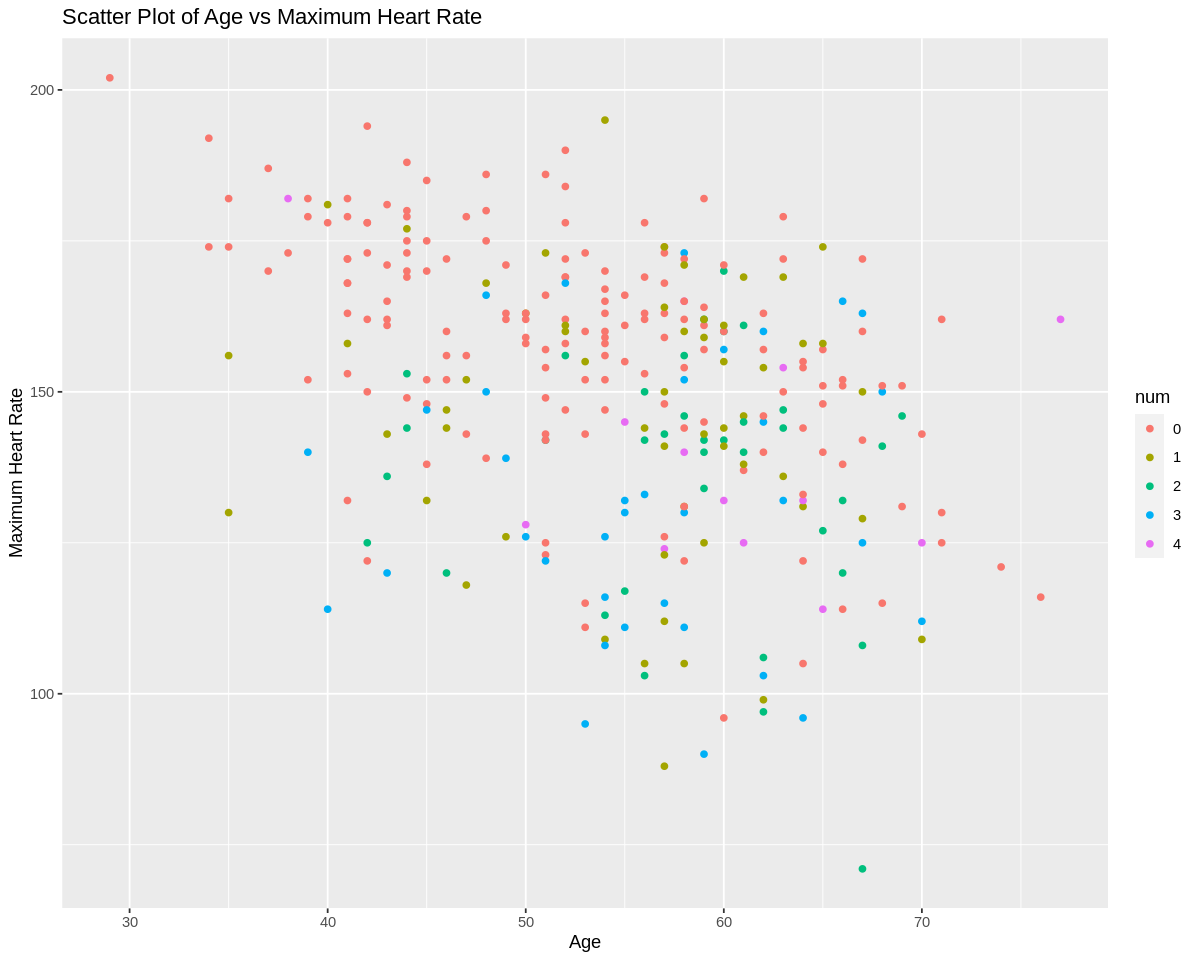

In [37]:
ggplot(heart_data, aes(x = age, y = thalach, color = num)) +
  geom_point() +
  labs(x = "Age", y = "Maximum Heart Rate") +
  ggtitle("Scatter Plot of Age vs Maximum Heart Rate")

## Discussion
### Summary of Results

### Expected findings and results
We expect to find that as all the selected variables increase, the respective num value should increase. Since heart disease is the narrowing of the blood vessels, there should be a positive relationship between blood pressure and heart disease. Cholesterol and maximum heart rate achieved are also great indicators of heart health. Low values in these variables correlate to good heart health, thus heart disease and these variables should also have a positive relationship. Finally, age and heart disease should have a positive relationship, as a person gets older, their overall health tends to decline. Therefore, the older the patient the greater the presence of heart disease, when looked over the entire 303 patients.

### Impact of findings and Future Questions
These findings could help determine if a patient has heart disease without doing any rigorous testing. The variables we selected are easily testable at any doctor’s office. A reliable way to predict heart disease could help save those who are affected each year. This data analysis could lead to further questions about if/how other variables correlate to heart disease. Or how you can reduce: cholesterol, resting bps, and maximum heart rate, if they in fact are positively correlated to heart disease.